# Aligning phonemes and words to audio

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import naplib as nl

In [2]:
outstruct = nl.io.load('../Alignment/out_NY834_small.pkl')
len(outstruct)

240

### Perform alignment using audio and text files

All sounds (.wav files) must be in one directory and all matching transcripts (.txt files) must be in another directory.

In [3]:
audio_dir = '../Alignment/sounds'
text_dir = '../Alignment/scripts'
output_dir = './alignment_output'

In [6]:
aligner = nl.alignment.Aligner()

aligner.align_from_files(audio_dir, text_dir, output_dir)

Resampling audio and putting in data_/ directory...
Converting text files to ascii in data_/ directory...
Performing alignment...
Converting .TextGrid files to .phn and .wrd in ./alignment_output
All done!


#### Let's look at some of the files that were created in the output_dir

In [22]:
!ls ./alignment_output | head -10

block-0-audio-00.TextGrid
block-0-audio-00.phn
block-0-audio-00.wrd
block-0-audio-01.TextGrid
block-0-audio-01.phn
block-0-audio-01.wrd
block-0-audio-02.TextGrid
block-0-audio-02.phn
block-0-audio-02.wrd
block-0-audio-03.TextGrid


### Specify a modified dictionary file if some words are not in the default dict

If there were words in our scripts that were not in the default dictionary, we can create our own dictionary file
by copying the [ProsodyLab eng.dict](https://github.com/prosodylab/Prosodylab-Aligner/blob/master/eng.dict) and adding lines for the words that we need. We can then put this new .dict file in the current path and specify it for the Aligner to use.

In [9]:
aligner = nl.alignment.Aligner(dictionary_file='../Alignment/eng_modified.dict')

aligner.align_from_files(audio_dir, text_dir, output_dir)

Resampling audio and putting in data_/ directory...
Converting text files to ascii in data_/ directory...
Performing alignment...
Converting .TextGrid files to .phn and .wrd in ./alignment_output
All done!


## Create array of phoneme and word labels across time for each trial

Now, we want to use the information in the .phn and .wrd files to generate an array of labels which shows what phoneme or word is currently happening at each point in time for each trial in our outstruct.

In [8]:
outstruct['resp'][0].shape

(942, 8)

In [9]:
phn_labels = [] # will store phoneme label vectors
manner_labels = [] # will store manner-of-articulation label vectors
wrd_labels = [] # will store word label vectors

# First we need to know all the word in our scripts so that we can assign them proper labels
wrd_dict = nl.alignment.create_wrd_dict(output_dir)

for n in range(len(outstruct)):
    
    # filenames for the .phn and .wrd files
    filename_phn = output_dir + '/' + outstruct[n]['name'] + '.phn'
    filename_wrd = output_dir + '/' + outstruct[n]['name'] + '.wrd'
    
    # desired length of the output label vector
    length = outstruct[n]['resp'].shape[0]
    
    # sampling rate of our data
    fs = 100
    
    # before-after period for our data. Typically this would just be outstruct[n]['befaft'],
    # but we are using truncated sound files for alignment compared to when the outstruct was generated
    befaft = outstruct[n]['befaft'] + np.array([1,0])
    
    # compute label vectors for phonemes, manner of articulation, and words, for this trial
    label_vec_phn = nl.alignment.get_phoneme_label_vector(filename_phn, length, fs, befaft)
    label_vec_manner = nl.alignment.get_phoneme_label_vector(filename_phn, length, fs, befaft, mode='manner')
    label_vec_wrd = nl.alignment.get_word_label_vector(filename_wrd, length, fs, befaft, wrd_dict=wrd_dict)
    
    phn_labels.append(label_vec_phn)
    manner_labels.append(label_vec_manner)
    wrd_labels.append(label_vec_wrd)
    
# Add the computed label vectors to the outstruct
outstruct['phn_labels'] = phn_labels
outstruct['manner_labels'] = manner_labels
outstruct['wrd_labels'] = wrd_labels

    

### Visualize the label vectors we created

For each trial in this outstruct, there is a beep, followed by 4 words.

Trial 0


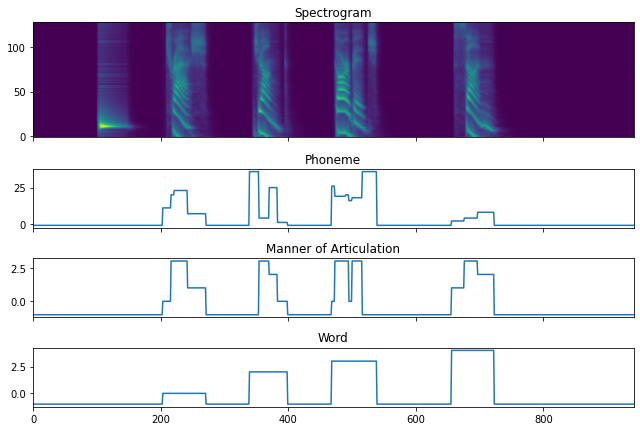

Trial 1


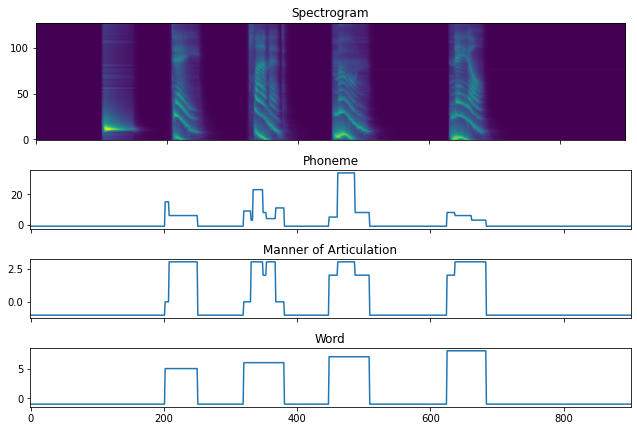

Trial 2


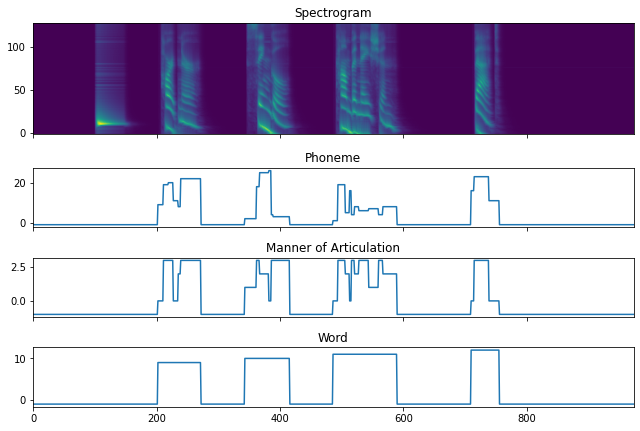

In [10]:
# Let's just look at the first 3 trials
for n, trial in enumerate(outstruct[:3]):
    
    print(f'Trial {n}')
    
    fig, axes = plt.subplots(4,1,figsize=(9,6), sharex=True, gridspec_kw={'height_ratios':[2,1,1,1]})
    
    axes[0].imshow(trial['aud'].T**.3, origin='lower', aspect=1.4)
    axes[0].set_title('Spectrogram')
    
    axes[1].plot(trial['phn_labels'])
    axes[1].set_title('Phoneme')
    
    axes[2].plot(trial['manner_labels'])
    axes[2].set_title('Manner of Articulation')
    
    axes[3].plot(trial['wrd_labels'])
    axes[3].set_title('Word')
    
    plt.tight_layout()
    
    plt.show()


## Looking at responses to word onsets

One simple thing we can look at using these label vectors is the neural response to word onsets.

In [11]:
segments, labels, prior_labels = nl.segmentation.segment_around_labeltransitions(outstruct, data='resp', labels='wrd_labels', prechange_samples=50, postchange_samples=200)

print((segments.shape, labels.shape, prior_labels.shape))


((1680, 250, 8), (1680,), (1680,))


We segmented the data into places where the word label changed. We only want to look at the segments where the word label changed from -1 (no word) to something, so we select only the segments where the label for that segment is > -1


In [12]:
segments = segments[labels>-1]
segments.shape

(960, 250, 8)

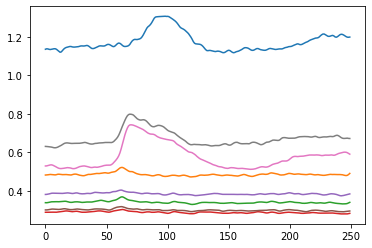

In [17]:
# plot the average word-onset response for each electrode
plt.figure()
plt.plot(segments.mean(0))
plt.show()